# Homework 5: Predicting Housing Prices

## Due Date: 6:00pm Tuesday, March 19

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the collaborators cell below.

**Collaborators:** *list names here*

## Introduction

In this homework, we will go through the iterative process of specifying, fitting, and analyzing the performance of a  model.  

In the first portion of the assignment, we will guide you through some basic exploratory data analysis (EDA), laying out the thought process that leads to certain modeling decisions. Next, you will add a new feature to the dataset, before specifying and fitting a linear model to a few features of the housing data to predict housing prices. Finally, we will analyze the error of the model and brainstorm ways to improve the model's performance.

After this homework, you should feel comfortable with the following:

1. Simple feature engineering
1. Using sklearn to build linear models
1. Building a data pipeline using pandas

Next week's homework will continue working with this dataset to address more advanced and subtle issues with modeling.

## Score Breakdown

Question | Points
--- | ---
[Question 1](#q1) | 3
[Question 2](#q2) | 2
[Question 3](#q3) | 1
[Question 4](#q4) | 1
[Question 5](#q5) | 2
[Question 6](#q6) | 2
[Question 7a](#q7a) | 1
[Question 7b](#q7b) | 2
[Question 8a](#q8a) | 1
[Question 8b](#q8b) | 1
[Question 8c](#q8c) | 2
[Question 8d](#q8d) | 2
Total | 20

In [ ]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# The Data

The [Chicago housing dataset](https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Assessment-Data/bcnq-qi2z) consists of over 350,000 records taken from Cook County's Assessor’s Office in Illinois describing houses sold in Cook County (Chicago and the surrounding area) in 2018.  The data set has 86(!) features in total.  An explanation of each variable can be found in the included `codebook.txt` file.  The information was used in computing assessed values for individual residential properties sold in Cook County, Illinois in 2018. This was done by the sitting Cook County Assesor, Kaegi, and their office.


## What is a County Assessor? A Living History

A county assessor is the person responsible for collecting estimates of parcels of land within a county, about every 3 years. The assessments of properties come from estimating what the property would be priced at or how much it would cost to construct the parcel, deducting depreciation. Assessments are done in order to determine the property taxes owed by the property owner. The Cook County Assessor, Fritz Kaegi, has promised to make assessments more transparent. This is a departure from the past Cook County Assessor, who has historically produced [“racially discriminatory assessments and taxes."](https://harris.uchicago.edu/news-events/news/prof-chris-berry-testifies-institutional-racism-cook-county-property-taxes)

In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios.  The lawsuit includes claims that the county assessor’s office undervalued homes in parts of Cook County where more white residents lived.  At the same time, Berrios’ office overvalued homes in areas with less white residents by census data.  [This forced non-white residents to pay more in property taxes](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html), [while white residents pay less](https://www.clccrul.org/bpnc-v-berrios-facts?rq=berrios).

Currently, the lawsuit is still underway and there was a third plaintiff added in February 2019.
This problem is systemic and historic as well, with property assessments for tax purposes placing an unequal and unfair tax burden on African American and Hispanic residents.  The county assessors role in our data is to come up with the parcels’ values.

## Cook County Open Data Initiative. A break from the past

The Cook County Open Data Initiative is an effort being conducted by numerous government  agencies in Cook County, opening data to the public on such diverse topics as “Emergency Management”, “Health”, “Courts and Legal”, and “Pets and Animals”. The Cook County Assessor’s Office (CCAO) is part of this initiative, and has published the data which generated their office’s model on how they value a house.

In essence, this data is the exact data that was used to generate the active model deployed by the CCAO to value houses in Cook County. [Access to their model (in R) can be found here](https://gitlab.com/ccao-data-science---modeling). Given that the data is publically accessible, the Cook County Assessor has solicited community member's input on the quality of the model. This effort includes soliciting comment on how their model may or may not reinforce biases that have been identified by many critics of the Cook County Assessors Office. This is a huge change from the previous practice of the Cook County Assessor's Office, which assigned house values manually with a team of assessors making decisions with little or no possible public oversight.

If you are interested in reading more about how this initiative is being presented by the CCAO, [you can read their Medium article](https://medium.com/@AssessorCook/why-the-cook-county-assessors-office-made-its-residential-assessment-code-and-data-public-c964acfa7b0f).

You can read more about the context of this data set from the [Cook Cook Assessor's Office Data Narrative](https://datacatalog.cookcountyil.gov/stories/s/Cook-County-Assessor-Valuation-Data-Release/p2kt-hk36).

In [ ]:
cook_county_housing = pd.read_csv('Cook_County_Assessor_s_Modeling_Data.csv')

In [ ]:
len(cook_county_housing.columns)

In [ ]:
len(cook_county_housing)

In [ ]:
# This makes the train-test split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_test_split in general
np.random.seed(1338)
full_data_len = len(cook_county_housing)
shuffled_indices = np.random.permutation(full_data_len)

# Set train_indices to the first 80% of shuffled_indices and and test_indices to the rest.
train_indices = shuffled_indices[:int(full_data_len * 0.8)]
test_indices = shuffled_indices[int(full_data_len * 0.8):]

# Create train and test` by indexing into `full_data` using 
# `train_indices` and `test_indices`
train_data = cook_county_housing.iloc[train_indices]
test_data = cook_county_housing.iloc[test_indices].drop('Sale Price', axis=1)

As a good sanity check, we should at least verify that the data shape matches the description.

In [1]:
# 228135 observations and 86 features in training data
assert train_data.shape == (228135, 86)
# 67034 observations and 85 features in test data
assert test_data.shape == (67034, 85)
# 'Sale Price' is hidden in the test data
assert 'Sale Price' not in test_data.columns.values
# Every other column in the test data should be in the training data
assert len(np.intersect1d(test_data.columns.values, 
                          train_data.columns.values)) == 85

NameError: name 'train_data' is not defined

## Separating the Training Data into Training and Testing Data

We need to separate out the data into training and test sections. This allows us to assess the strength of our model on the test data after we train it on the training data.

In [ ]:
# This makes the train-test split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_test_split in general
np.random.seed(1338)
train_data_len = len(train_data)
shuffled_indices = np.random.permutation(train_data_len)

# Set train_indices to the first 80% of shuffled_indices and and test_indices to the rest.
train_indices = shuffled_indices[:int(train_data_len * 0.8)]
test_indices = shuffled_indices[int(train_data_len * 0.8):]

# Create train and test` by indexing into `full_data` using 
# `train_indices` and `test_indices`
training_data = train_data.iloc[train_indices]
testing_data = train_data.iloc[test_indices]

# Part 0: Contextualizing the Data

The next order of business is to contextualize the variables in our data.  The Cook County data set contains information that the CCAO has deemed important to assess home value.  A more detailed description of each variable is available on [their website](https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Modeling-Data/5pge-nu6u). The list of column values there contains notes on what each value or string represents, and sometimes cautions about the quality of a given variable.  **You should take some time to familiarize yourself with the variables before moving forward.**

In [2]:
cook_county_housing.columns.values

NameError: name 'cook_county_housing' is not defined

## Question 0a

Take a moment to assess the granularity of this data set. What is contained in a row?

*Write your response here*

## Question 0b

Given that this data represents houses, do you think there are enough features and types of features to give an accurate picture of a home’s value?

*Write your response here*

## Question 0c

Given that this data was used by the Cook County Assessor's Office to generate the model that they employ today, name two columns that have probably been added by the data scientists.

*Hint* You can go back to the list of columns from the CCAO's wesbite or you can generate a list of the columns in this data set

In [73]:
##Leave your scratch work here

*Write your response here*

Solution: There are many instances of columns that have been duplicated as a square or log of a previous column

## Question 0d

Recalling that these columns were collected by the Cook County Assessor's Office to generate house values, find a column that more than likely would only be collected in Cook County. 

*Write your response here*

Solution: O'Hare noise column would only be relevant to Cook County becase it represents whether or not a house is in flight paths of the Chicago O'Hare Airport.

# Part 1: Exploratory Data Analysis

In this section, we will make a series of exploratory visualizations and interpret them.

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### Sale Price
We begin by examining a [raincloud plot](https://micahallen.org/2018/03/15/introducing-raincloud-plots/amp/?__twitter_impression=true) (a combination of a KDE, a histogram, a strip plot, and a box plot) of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable.

*Write your response here*

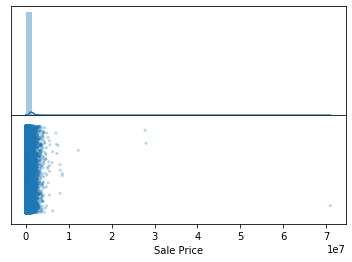

In [48]:
fig, axs = plt.subplots(nrows=2)

sns.distplot(
    training_data['Sale Price'], 
    ax=axs[0]
)
sns.stripplot(
    training_data['Sale Price'], 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    training_data['Sale Price'],
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(training_data['Sale Price']) * 0.05
xmin = np.min(training_data['Sale Price']) - spacer
xmax = np.max(training_data['Sale Price']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].artists[0].set_facecolor('white')

In [49]:
training_data['Sale Price'].describe()

count    2.145080e+05
mean     2.399628e+05
std      3.504762e+05
min      0.000000e+00
25%      5.100000e+04
50%      1.700000e+05
75%      3.070000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

**Omit Below Cell**

## Question 1  <a name="q1"></a>
To check your understanding of the graph and summary statistics above, answer the following `True` or `False` questions:

1. The distribution of `SalePrice` in the training set is left-skew.
1. The mean of `SalePrice` in the training set is greater than the median.
1. At least 25% of the houses in the training set sold for more than \$200,000.00.

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned each variable to `True` or `False`.*

<!--
BEGIN QUESTION
name: q1
points: 3
-->

## Question 1  <a name="q1"></a>
To check your understanding of the graph and summary statistics above, answer the following `True` or `False` questions:

1. The distribution of `SalePrice` in the training set is left-skew.
1. The mean of `SalePrice` in the training set is greater than the median.
1. At least 25% of the houses in the training set sold for more than \$200,000.00.

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned each variable to `True` or `False`.*

<!--
BEGIN QUESTION
name: q1
points: 3
-->

## Question 3 <a name="q3"></a>

We know from the data narrative that this dataset primarily consists of house sales. However, there are still many rows which have sale price numbers which are much below what any reasonable property would sell for. There are 1557 rows with the value 0, and 50 other rows with values at or below 10. Remove these values and the outliers of houses which sold for more than 10 million with the remove_outliers function given below.

In [3]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data.loc[(data[variable] > lower) & (data[variable] < upper), :]

training_data = remove_outliers(training_data, 'Sale Price', upper=10000000, lower=10)

NameError: name 'np' is not defined

In [4]:
ok.grade("q3");

NameError: name 'ok' is not defined

# Part 2: Feature Engineering

In this section we will create a new feature out of existing ones through a simple data transformation.

Feature engineering is a critical point in the data science process. We are essentially saying "These are the features we feel are important to predicting our metric." A good data scientist balances statistical reasoning and their own critical thinking.

### Bathrooms

Let's create a groundbreaking new feature. Due to recent advances in Universal WC Enumeration Theory, we now know that Total Bathrooms can be calculated as:

$$ \text{TotalBathrooms}=(\text{BsmtFullBath} + \text{FullBath}) + \dfrac{1}{2}(\text{BsmtHalfBath} + \text{HalfBath})$$

The actual proof is beyond the scope of this class, but we will use the result in our model.

## Question 4 <a name="q4"></a>

Write a function `add_total_bathrooms(data)` that returns a copy of `data` with an additional column called `TotalBathrooms` computed by the formula above.  **Treat missing values as zeros**.  Remember that you can make use of vectorized code here; you shouldn't need any `for` statements. 

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

In [5]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    """
    with_bathrooms = data.copy()
    bath_vars = ['Full Baths', 'Half Baths']
    weights = pd.Series([1, 0.5], index=bath_vars)
    ## Solution
    with_bathrooms = with_bathrooms.fillna({var: 0 for var in bath_vars})
    with_bathrooms['Total Bathrooms'] = with_bathrooms[bath_vars].dot(weights)
    return with_bathrooms

training_data = add_total_bathrooms(training_data)

NameError: name 'training_data' is not defined

In [ ]:
ok.grade("q4");

## Question 5 <a name="q5"></a>

Create a visualization that clearly and succintly shows that `TotalBathrooms` is associated with `SalePrice`. Your visualization should avoid overplotting.

In [6]:
# BEGIN SOLUTION
sns.boxplot(x='Total Bathrooms', y='Sale Price', data=training_data, whis=5);
plt.title('Sale Price distribution for each value of Total Bathrooms');
# END SOLUTION

NameError: name 'sns' is not defined

# Part 3: Modeling

We've reached the point where we can specify a model. But first, we will load a fresh copy of the data, just in case our code above produced any undesired side-effects. Run the cell below to store a fresh copy of the data from `ames_train.csv` in a dataframe named `full_data`. We will also store the number of rows in `full_data` in the variable `full_data_len`.

In [ ]:
# Load a fresh copy of the data and get its length
full_data = pd.read_csv('Cook_County_Assessor_s_Modeling_Data.csv')
full_data_len = len(full_data)
full_data.head()

## Question 6 <a name="q6"></a>

Now, let's split the data set into a training set and test set. We will use the training set to fit our model's parameters, and we will use the test set to estimate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on unseen data.

"Don't we already have a test set in `ames_test.csv`?" you might wonder. The sale prices for `ames_test.csv` aren't provided, so we're constructing our own test set for which we know the outputs.

In the cell below, split the data in `full_data` into two DataFrames named `train` and `test`. Let `train` contain 80% of the data, and let `test` contain the remaining 20% of the data. 

To do this, first create two NumPy arrays named `train_indices` and `test_indices`. `train_indices` should contain a *random* 80% of the indices in `full_data`, and `test_indices` should contain the remaining 20% of the indices. Then, use these arrays to index into `full_data` to create your final `train` and `test` DataFrames.

*The provided tests check that you not only answered correctly, but ended up with the exact same train/test split as our reference implementation. Later testing is easier this way.*

In [ ]:
# This makes the train-test split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_test_split in general
np.random.seed(1337)
shuffled_indices = np.random.permutation(full_data_len)

# Set train_indices to the first 80% of shuffled_indices and and test_indices to the rest.
train_indices = shuffled_indices[:int(full_data_len * 0.8)] # SOLUTION
test_indices = shuffled_indices[int(full_data_len * 0.8):] # SOLUTION

assert len(train_indices) != len(test_indices)

# Create train and test` by indexing into `full_data` using 
# `train_indices` and `test_indices`
train = full_data.iloc[train_indices] # SOLUTION
test = full_data.iloc[test_indices] # SOLUTION

In [ ]:
ok.grade("q6");

### Reusable Pipeline

Throughout this assignment, you should notice that your data flows through a single processing pipeline several times.  From a software engineering perspective, it's best to define functions/methods that can apply the pipeline to any dataset.  We will now encapsulate our entire pipeline into a single function `process_data_gm`.  gm is shorthand for "guided model". We select a handful of features to use from the many that are available.

Additionally, creating reproducible work is an important part of data science. When you leave a project, readability and transferability of your code is necessary for future work on the project by other data scientists. Therefore, it’s better to use abstract identifiers to navigate code. For example, in this notebook, we refer to columns by their names--that way, if a new dataset comes in with different column indices, we’ll be able to know which columns to target when adapting code. 

In the CCAO's case, for example, they felt that making their model into a reproducible and easily reusable pipeline was an essential part of their mission as a public office. In this case, this allows citizens and other entities with sufficient technical skills to understand and even critique their work openly.


In [64]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_gm(data):
    """Process the data for a guided model."""
    
    data = remove_outliers(data, 'Sale Price', upper=10000000, lower=0)
    data = add_total_bathrooms(data)
    
    
    data = data.dropna(subset=['Sale Price', 'Building Square Feet', 
                                 'Full Baths', 'Half Baths',
                                 'Bedrooms', 'Land Square Feet',
                                 'Rooms', 'Fireplaces'])
    
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'Sale Price', 
                          'Land Square Feet',
                          'Full Baths',
                          'Building Square Feet',
                          'Rooms',
                          'Fireplaces')
    
    # Return predictors and response variables separately
    X = data.drop(['Sale Price'], axis = 1)
    y = data.loc[:, 'Sale Price']
    
    return X, y

Now, we can use `process_data_gm1` to clean our data, select features, and add our `TotalBathrooms` feature all in one step! This function also splits our data into `X`, a matrix of features, and `y`, a vector of sale prices. 

Run the cell below to feed our training and test data through the pipeline, generating `X_train`, `y_train`, `X_test`, and `y_test`.

In [65]:
# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!
X_train, y_train = process_data_gm(train)
X_test, y_test = process_data_gm(test)

### Fitting Our First Model

We are finally going to fit a model!  The model we will fit can be written as follows:

$$\text{SalePrice} = \theta_0 + \theta_1 \cdot \text{Gr_Liv_Area} + \theta_2 \cdot \text{Garage_Area} + \theta_3 \cdot \text{TotalBathrooms}$$

In vector notation, the same equation would be written:

$$y = \vec\theta \cdot \vec{x}$$

where $y$ is the SalePrice, $\vec\theta$ is a vector of all fitted weights, and $\vec{x}$ contains a 1 for the bias followed by each of the feature values.

**Note:** Notice that all of our variables are continuous, except for `TotalBathrooms`, which takes on discrete ordered values (0, 0.5, 1, 1.5, ...). In this homework, we'll treat `TotalBathrooms` as a continuous quantitative variable in our model, but this might not be the best choice. The next homework may revisit the issue.

## Question 7a <a name="q7a"></a>

We will use a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object as our linear model. In the cell below, create a `LinearRegression` object and name it `linear_model`.

**Hint:** See the `fit_intercept` parameter and make sure it is set appropriately. The intercept of our model corresponds to $\theta_0$ in the equation above.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

In [ ]:
from sklearn import linear_model as lm

linear_model = lm.LinearRegression(fit_intercept=True) # SOLUTION

## Question 7b <a name="q7b"></a>

Now, remove the commenting and fill in the ellipses `...` below with `X_train`, `y_train`, `X_test`, or `y_test`.

With the ellipses filled in correctly, the code below should fit our linear model to the training data and generate the predicted sale prices for both the training and test datasets.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

In [68]:
# Uncomment the lines below and fill in the ... with X_train, y_train, X_test, or y_test.
# linear_model.fit(..., ...)
# y_fitted = linear_model.predict(...)
# y_predicted = linear_model.predict(...)
# BEGIN SOLUTION NO PROMPT

linear_model.fit(X_train, y_train)
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_test)
# END SOLUTION

In [69]:
ok.grade("q7b");

NameError: name 'ok' is not defined

## Question 8a <a name="q8a"></a>

Is our linear model any good at predicting house prices? Let's measure the quality of our model by calculating the Root-Mean-Square Error (RMSE) between our predicted house prices and the true prices stored in `SalePrice`.

$$\text{RMSE} = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price of house} - \text{predicted price of house})^2}{\text{# of houses in data set}}}$$

In the cell below, write a function named `rmse` that calculates the RMSE of a model.

**Hint:** Make sure you are taking advantage of vectorized code. This question can be answered without any `for` statements.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

In [7]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array): vector of actual values
      predicted (1D array): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2)) # SOLUTION

In [71]:
ok.grade("q8a");

NameError: name 'ok' is not defined

## Question 8b <a name="q8b"></a>

Now use your `rmse` function to calculate the training error and test error in the cell below.

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned each variable to a non-negative number.*

In [72]:
training_error = rmse(y_fitted, y_train) # SOLUTION
test_error = rmse(y_predicted, y_test) # SOLUTION
(training_error, test_error)

(260674.5844381157, 258144.35809396824)

In [146]:
ok.grade("q8b");

NameError: name 'ok' is not defined

## Question 8c <a name="q8c"></a>

How much does including `TotalBathrooms` as a predictor reduce the RMSE of the model on the test set? That is, what's the difference between the RSME of a model that only includes `Gr_Liv_Area` and `Garage_Area` versus one that includes all three predictors?

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned the answer variable to a non-negative number.*

In [ ]:
test_error_difference = test_error_no_bath - test_error
test_error_difference

In [ ]:
ok.grade("q8c");



### Residual Plots

One way of understanding the performance (and appropriateness) of a model is through a residual plot. Run the cell below to plot the actual sale prices against the residuals of the model for the test data.

In [ ]:
residuals = y_test - y_predicted
ax = sns.regplot(y_test, residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. Sale Price on Test Data");

Ideally, we would see a horizontal line of points at 0 (perfect prediction!). The next best thing would be a homogenous set of points centered at 0. 

But alas, our simple model is probably too simple. The most expensive homes are systematically more expensive than our prediction. 

## Question 8d <a name="q8c"></a>

What changes could you make to your linear model to improve its accuracy and lower the test error? Suggest at least two things you could try in the cell below, and carefully explain how each change could potentially improve your model's accuracy.

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 2 EXPORTED QUESTIONS -->

In [ ]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('hw5.ipynb', 'hw5.pdf')
ok.submit()

In [ ]:
# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 2 EXPORTED QUESTIONS -->

# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('hw5.ipynb', 'hw5.pdf')
ok.submit()